In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [ ]:
cd /content/drive/MyDrive/gender detection

/content/drive/MyDrive/gender detection


In [ ]:
path = Path("UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [ ]:
print(len(filenames))
print(filenames[:3])

23708
['75_0_1_20170111211400077.jpg.chip.jpg', '9_1_2_20161219204347420.jpg.chip.jpg', '75_0_0_20170117192228563.jpg.chip.jpg']


In [ ]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels
df.head()

,image,age,gender
0,63_0_1_20170117182443400.jpg.chip.jpg,63,0
1,4_1_0_20170109191155398.jpg.chip.jpg,4,1
2,40_0_0_20170116211616639.jpg.chip.jpg,40,0
3,28_1_2_20170116190142300.jpg.chip.jpg,28,1
4,21_0_2_20170116164809162.jpg.chip.jpg,21,0


In [ ]:
gender_dict = {0:"Male",1:"Female"}
df = df.astype({'age':'float32', 'gender': 'int32'})
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


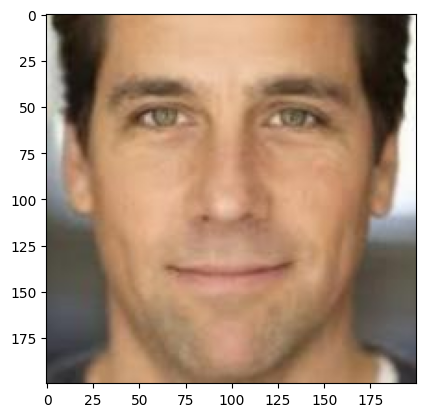

In [ ]:
img = Image.open("UTKFace/"+df.image[5])
plt.imshow(img)

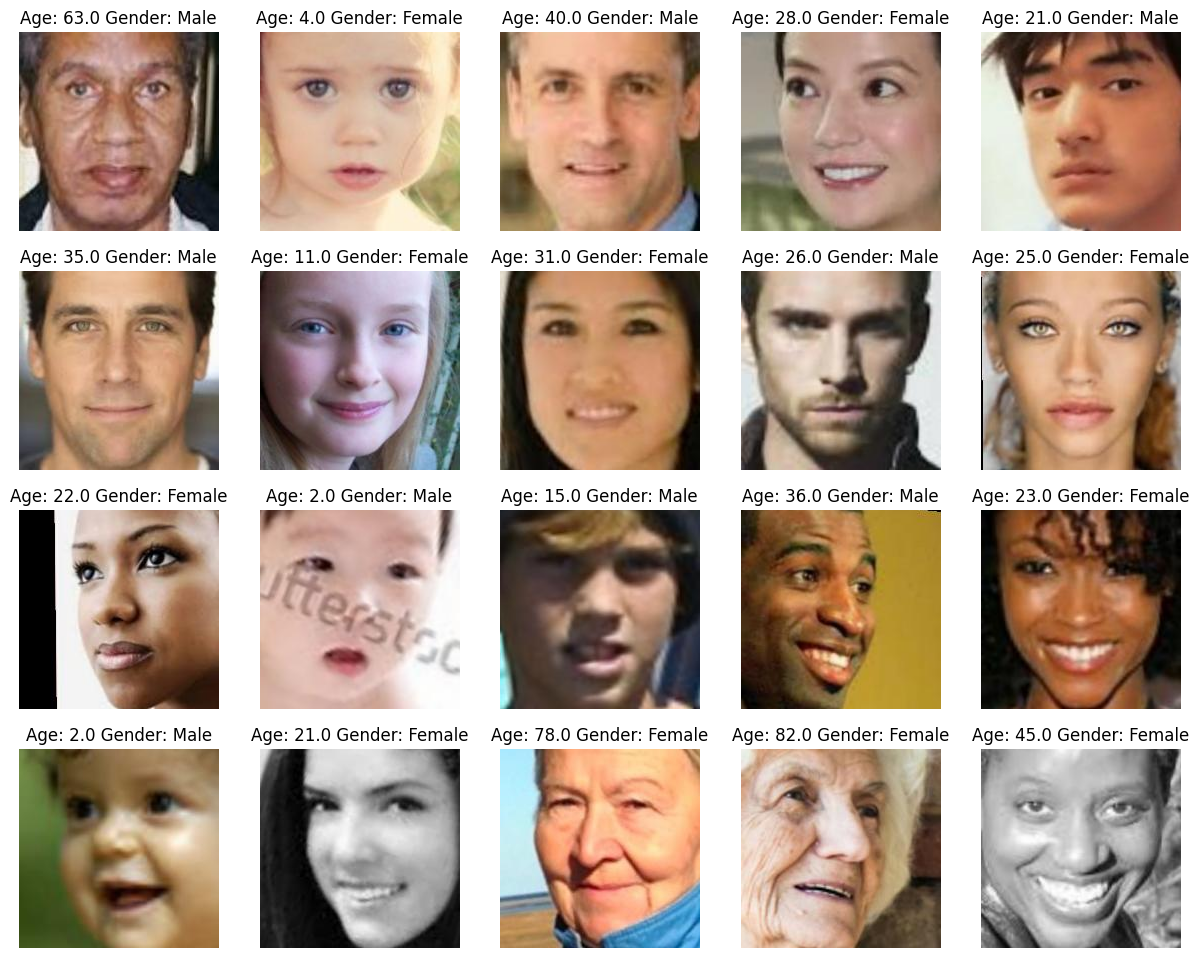

In [ ]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train.head()

,image,age,gender
5096,80_1_0_20170120221022764.jpg.chip.jpg,80.0,1
19586,1_1_3_20161220143357382.jpg.chip.jpg,1.0,1
9835,32_1_4_20170105164210618.jpg.chip.jpg,32.0,1
13631,33_1_0_20170117171111730.jpg.chip.jpg,33.0,1
9807,26_0_2_20170116181245176.jpg.chip.jpg,26.0,0


In [ ]:
len(train)

18966

In [ ]:
len(df)

23708

In [ ]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)
x_train = np.array(x_train)
x_train = x_train.reshape(len(x_train), 128,128,1)

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-16-01901eb87d5d>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [ ]:
import pickle

# Save the x_train numpy array to a file
with open('x_train.pkl', 'wb') as file:
    pickle.dump(x_train, file)


In [ ]:
import pickle

# Load the x_train numpy array from the pickle file
with open('x_train.pkl', 'rb') as file:
    x_train = pickle.load(file)


In [ ]:
x_train.shape

(18966, 128, 128, 1)

In [ ]:
x_train = x_train/255

In [ ]:
x_train.shape

(3557, 128, 128, 1)

In [ ]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
input_size = (128,128,1)

In [ ]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)
X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)
X = Flatten()(X)
dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
model = Model(inputs=[inputs], outputs=[output_1])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import backend as K
from tensorflow.keras.optimizers import Adam




In [ ]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf
import pickle

# Define a custom callback to save the training history after each epoch
class SaveHistory(Callback):
    def __init__(self, filename):
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'wb') as file:
            pickle.dump(self.model.history.history, file)

# Concatenate the list of target tensors into a single tensor
y_gender_concatenated = tf.concat(y_gender, axis=-1)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Define a callback to save the training history after each epoch
save_history_callback = SaveHistory('model_history.pkl')

# Train the model with early stopping and history saving
model_history = model.fit(
    x=x_train,
    y=y_gender_concatenated,
    batch_size=50,
    epochs=5,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint, save_history_callback]
)


Epoch 1/5
342/342 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.7918

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


342/342 [==============================] - 1080s 3s/step - loss: 0.4439 - accuracy: 0.7918 - val_loss: 0.3602 - val_accuracy: 0.8471
Epoch 2/5
342/342 [==============================] - 1086s 3s/step - loss: 0.3501 - accuracy: 0.8419 - val_loss: 0.3726 - val_accuracy: 0.8382
Epoch 3/5
342/342 [==============================] - 1087s 3s/step - loss: 0.3205 - accuracy: 0.8603 - val_loss: 0.3320 - val_accuracy: 0.8461
Epoch 4/5
342/342 [==============================] - 1061s 3s/step - loss: 0.2956 - accuracy: 0.8726 - val_loss: 0.3155 - val_accuracy: 0.8577
Epoch 5/5
 32/342 [=>............................] - ETA: 15:31 - loss: 0.2771 - accuracy: 0.8894

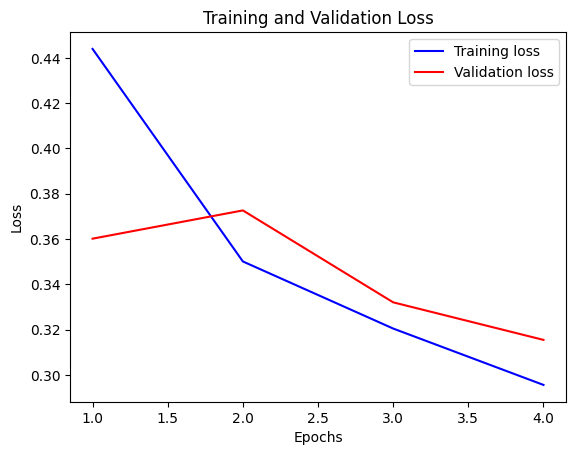

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the training history from the pickle file
with open('model_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Extract loss and validation loss values
loss = history['loss']
val_loss = history['val_loss']

# Create a range of epochs for x-axis
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:

index = 50
print("Original: Gender =", gender_dict[y_gender[index]])

pred_gender = model.predict(x_train[index].reshape(1, 128, 128, 1))
print("Shape of pred_gender:", pred_gender.shape)
print("Contents of pred_gender:", pred_gender)

if pred_gender.shape == (1, 1):
    pred_gender = gender_dict[round(pred_gender[0][0])]  # Predicted gender
    print("Prediction: Gender =", pred_gender)
else:
    print("Unexpected shape of pred_gender array. Please check your model's output shape.")


Original: Gender = Female
1/1 [==============================] - 0s 207ms/step
Shape of pred_gender: (1, 1)
Contents of pred_gender: [[0.9119813]]
Prediction: Gender = Female


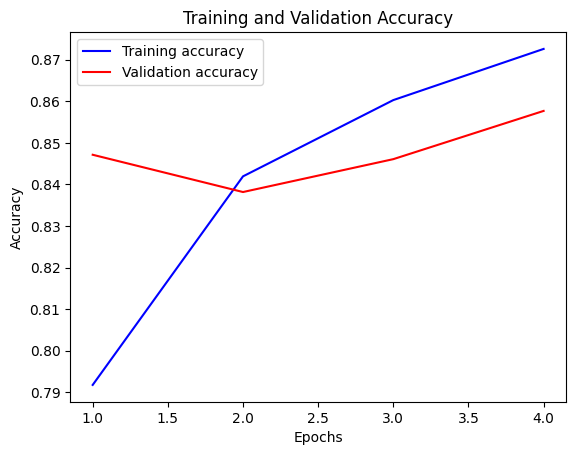

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the training history from the pickle file
with open('model_history.pkl', 'rb') as file:
    history = pickle.load(file)

# Extract accuracy and validation accuracy values
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Create a range of epochs for x-axis
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
true_labels = df['gender'].values
len(true_labels)

23708

FileUpload(value={}, accept='.jpg', description='Upload')

Output()

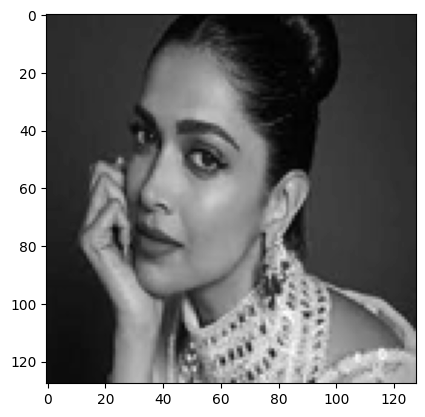

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from ipywidgets import FileUpload, Output
import io

# Load the pre-trained gender classification model
model = tf.keras.models.load_model('best_model.h5')

# Function to guess the gender of a new image
def guess_gender(new_img):
    # Convert the image to grayscale
    new_img = new_img.convert('L')
    new_img = image.img_to_array(new_img)
    new_img = np.expand_dims(new_img, axis=0)
    new_img = new_img / 255.0

    # Make a prediction
    prediction = model.predict(new_img)

    # Check the shape of the prediction
    if prediction.shape == (1, 1):
        predicted_gender = gender_dict[round(prediction[0][0])]  # Predicted gender
        return predicted_gender
    else:
        return "Unexpected shape of prediction array. Please check your model's output shape."

# Create an output widget for displaying the prediction
output_widget = Output()

# Function to handle file upload and display prediction
def handle_upload(change):
    with output_widget:
        # Clear the previous output
        output_widget.clear_output()

        # Get the uploaded image
        uploaded_image = list(file_upload.value.values())[0]['content']
        new_img = Image.open(io.BytesIO(uploaded_image))

        # Resize and convert the image to grayscale
        new_img = new_img.resize((128, 128))
        new_img = new_img.convert('L')
        plt.imshow(new_img, cmap='gray')

        # Predict the gender
        predicted_gender = guess_gender(new_img)

        # Display the result
        print("Prediction: Gender =", predicted_gender)

# Create a file upload widget
file_upload = FileUpload(accept='.jpg', multiple=False)
file_upload.observe(handle_upload, names='value')

# Display the widgets
display(file_upload, output_widget)
